<H1>scDRS tutorial</H1>
Implementation of the scDRS tutorial provided by the authors.

This is the scDRS tutorial found here: https://martinjzhang.github.io/scDRS/notebooks/quickstart.html

In [ ]:
DATA_FOLDER = "../data/tutorial/"

# Imports
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=125)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

In this example the following data is used:

1. SCZ: Schizophrenia (SCZ) gene sets obtained from GWAS summary statistics, which is the disease of interest in this demo.

2. Dorsal: Differentially expressed genes in dorsal CA1 pyramidal obtained from Cembrowski et al. 2016, which we will used to construct dorsal score indicating the proximity to the dorsal CA1, which we find useful to understand the spatial distribution of SCZ disease enrichment.

3. Height: Height gene sets obtained from GWAS summary statistics, which we use as a negative control trait.

In [2]:
DATA_DIR = Path("../Data/SCDRS/tutorial")

# scdrs.util.load_h5ad is a simple wrapper to read h5ad files
# with basic data filtering
adata = scdrs.util.load_h5ad(
    h5ad_file=DATA_DIR / "expr.h5ad", flag_filter_data=True, flag_raw_count=True
)

# load geneset, convert homologs and overlap gene names to adata.var_names
dict_gs = scdrs.util.load_gs(
    DATA_DIR / "processed_geneset.gs",
    src_species="mouse",
    dst_species="mouse",
    to_intersect=adata.var_names,
)

# load covariates
df_cov = pd.read_csv(DATA_DIR / "cov.tsv", sep="\t", index_col=0)

# preprocess data to
# (1) regress out from covariates
# (2) group genes into bins by mean and variance
scdrs.preprocess(adata, cov=df_cov, n_mean_bin=20, n_var_bin=20, copy=False)

In [3]:
# what is gene dict?

count = 0
for key in dict_gs.keys():
    count, highest_nr, lowest_nr = 0, 0, 0
    print(f'{key} genes: {len(dict_gs[key][1])}')
    for idx, nr in enumerate(dict_gs[key][1]):
        if nr != 1:
            if nr > highest_nr:
                highest_nr = nr

            if nr < lowest_nr:
                lowest_nr = nr
            count += 1
            # print(f"val: {nr}")
    
    print(f'nr of weights != 0: {count}')
    print(f'highest weight: {highest_nr}')
    print(f'lowest weight: {lowest_nr}\n')


SCZ genes: 756
nr of weights != 0: 756
highest weight: 7.6519
lowest weight: 0

Dorsal genes: 155
nr of weights != 0: 0
highest weight: 0
lowest weight: 0

Height genes: 671
nr of weights != 0: 671
highest weight: 10.0
lowest weight: 0



In [4]:
# Assign cell scores for each trait
dict_df_score = dict()
for trait in dict_gs:
    gene_list, gene_weights = dict_gs[trait]
    dict_df_score[trait] = scdrs.score_cell(
        data=adata,
        gene_list=gene_list,
        gene_weight=gene_weights,
        ctrl_match_key="mean_var",
        n_ctrl=1000,
        weight_opt="vs",
        return_ctrl_raw_score=False,
        return_ctrl_norm_score=True,
        verbose=False,
    )

Computing control scores: 100%|██████████| 1000/1000 [00:21<00:00, 47.21it/s]


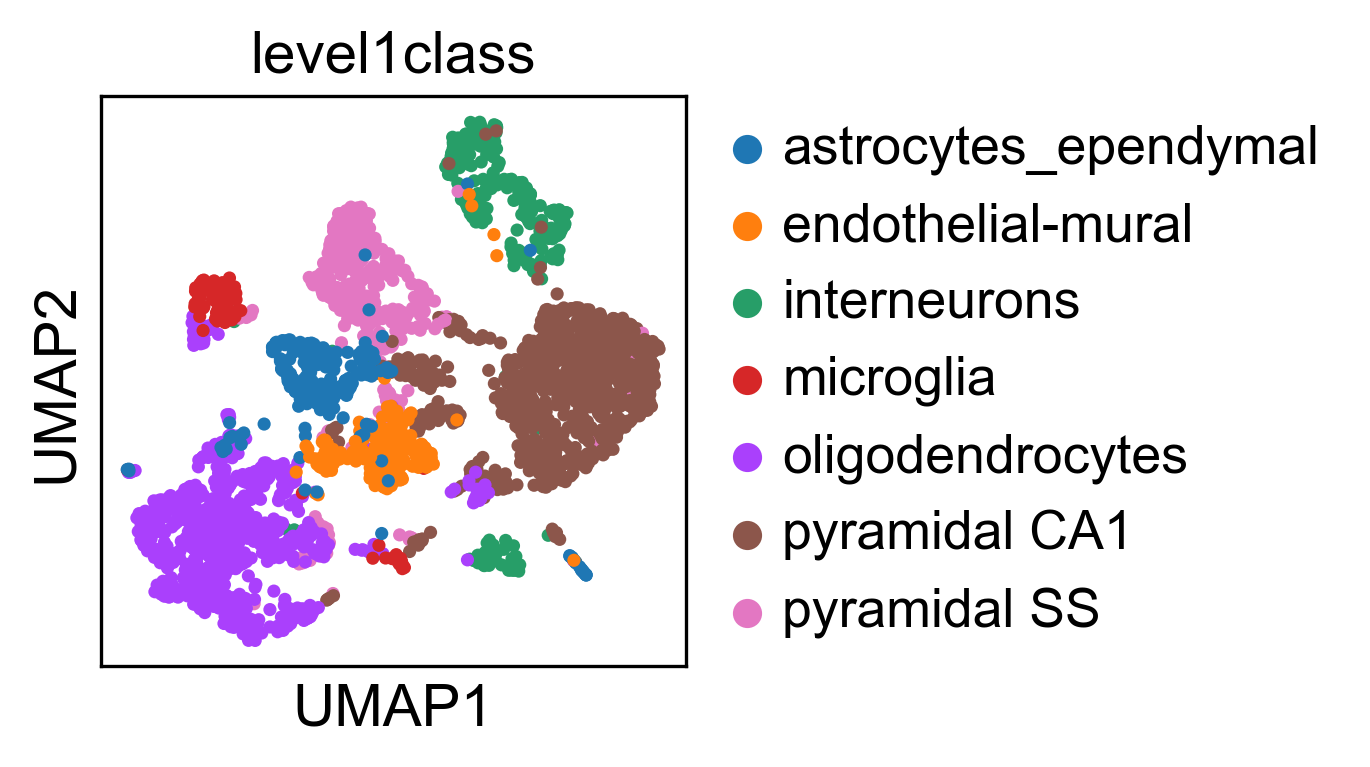

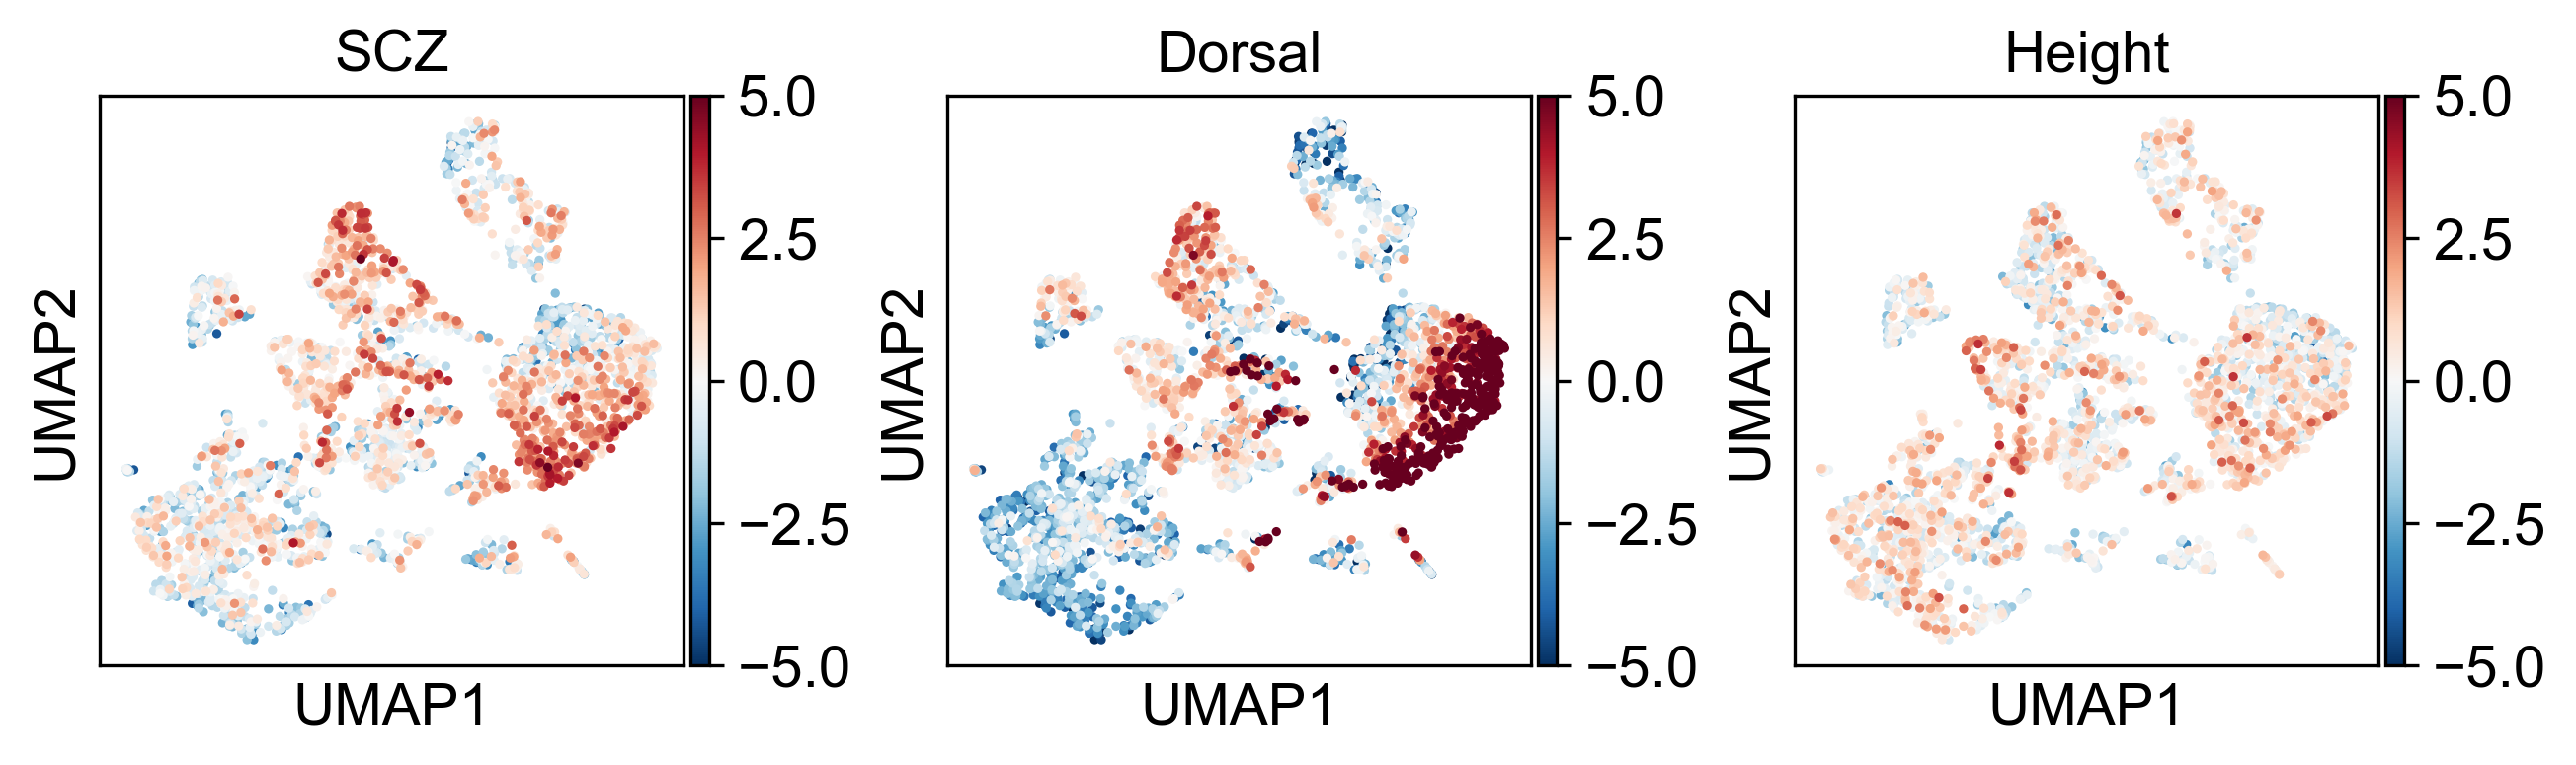

In [5]:
for trait in dict_df_score:
    adata.obs[trait] = dict_df_score[trait]["norm_score"]

sc.set_figure_params(figsize=[2.5, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color="level1class",
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

sc.pl.umap(
    adata,
    color=dict_df_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
)

In [6]:
df_stats = scdrs.method.downstream_group_analysis(
    adata=adata,
    df_full_score=dict_df_score["SCZ"],
    group_cols=["level1class"],
)["level1class"]

display(df_stats.style.set_caption("Group-level statistics for SCZ"))

,n_cell,n_ctrl,assoc_mcp,assoc_mcz,hetero_mcp,hetero_mcz,n_fdr_0.05,n_fdr_0.1,n_fdr_0.2
group,,,,,,,,,
astrocytes_ependymal,224.000000,1000.000000,0.007992,2.755896,0.002997,3.035255,6.000000,12.000000,23.000000
endothelial-mural,235.000000,1000.000000,0.140859,1.044123,0.051948,1.825429,6.000000,9.000000,11.000000
interneurons,290.000000,1000.000000,0.179820,0.851682,0.005994,3.029441,0.000000,3.000000,13.000000
microglia,98.000000,1000.000000,0.439560,0.097814,0.177822,0.930176,0.000000,2.000000,3.000000
oligodendrocytes,820.000000,1000.000000,0.767233,-0.731655,0.000999,5.037367,1.000000,4.000000,11.000000
pyramidal CA1,939.000000,1000.000000,0.000999,7.707747,0.000999,9.697396,50.000000,105.000000,189.000000
pyramidal SS,399.000000,1000.000000,0.000999,5.788910,0.000999,6.059032,26.000000,43.000000,70.000000


**We use scdrs perform-downstream to obtain the group-level statistics. The function will return the following statistics for each cell type:**

1. assoc_mcp: significance of cell type-disease association

2. hetero_mcp: significance heterogeneity in association with disease across individual cells within a given cell type

3. n_fdr_0.1: number of significantly associated cells (with FDR0.1 across all cells for a given disease)

In [ ]:
dict_celltype_display_name = {
    "pyramidal_CA1": "Pyramidal CA1",
    "oligodendrocytes": "Oligodendrocyte",
    "pyramidal_SS": "Pyramidal SS",
    "interneurons": "Interneuron",
    "endothelial-mural": "Endothelial",
    "astrocytes_ependymal": "Astrocyte",
    "microglia": "Microglia",
}

fig, ax = scdrs.util.plot_group_stats(
    dict_df_stats={
        trait: df_stats.rename(index=dict_celltype_display_name)
        for trait, df_stats in df_stats.items()
    },
    plot_kws={
        "vmax": 0.2,
        "cb_fraction":0.12
    }
)

In [ ]:
# extract CA1 pyramidal neurons and perform a re-clustering
adata_ca1 = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])].copy()
sc.pp.filter_cells(adata_ca1, min_genes=0)
sc.pp.filter_genes(adata_ca1, min_cells=1)
sc.pp.normalize_total(adata_ca1, target_sum=1e4)
sc.pp.log1p(adata_ca1)

sc.pp.highly_variable_genes(adata_ca1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_ca1 = adata_ca1[:, adata_ca1.var.highly_variable]
sc.pp.scale(adata_ca1, max_value=10)
sc.tl.pca(adata_ca1, svd_solver="arpack")

sc.pp.neighbors(adata_ca1, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_ca1, n_components=2)

# assign scDRS score
for trait in dict_score:
    adata_ca1.obs[trait] = dict_score[trait]["norm_score"]
